In [436]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import rc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import time

from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [543]:
df = pd.read_pickle('data/SRP/clean_data_public_no_crime.pkl')

In [544]:
# make sure to do customer profile analysis before this
df = df.join(cust_table_clust, on='address1', how='left')

# Split into features vs targets

In [585]:
def X_y(df, non_feature_cols, target_col):
    non_feature_data = df[non_feature_cols]
    features = list(set(df) - set(non_feature_cols))
    features.sort()
    X = df[features]
    y = non_feature_data[target_col]
    return X, y

In [586]:
def time_split(df, date_col, date, non_feature_cols, target_col):
    df_train = df[ df[date_col] < date ]
    df_test = df[ df[date_col] >= date ]
    X_train, y_train = X_y(df_train, non_feature_cols, target_col)
    X_test, y_test = X_y(df_test, non_feature_cols, target_col)
    return X_train, X_test, y_train, y_test

In [622]:
# split into features and targets
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day']
X, y = X_y(df, non_feature_cols, target_col='shrink_value_per_day')
# del df # free up memory

In [623]:
# random split for model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X.cluster.values)

# time split for forcast
split_date = pd.to_datetime('12/01/2017')
forc_X_train, forc_X_test, forc_y_train, forc_y_test = time_split(df, 'visit_date', split_date, 
                                                                  non_feature_cols, target_col='shrink_value_per_day')

# Standardize and Scale

In [624]:
def std_f(X_std):
    std_mask = (X_std.dtypes == int) | (X_std.dtypes == np.float64) # only standardize numbers that are not associated with time features
    std_cols = X_std.columns[std_mask]
    ss = StandardScaler()
    X_std[std_cols] = ss.fit_transform(X_std[std_cols])
    return X_std

In [625]:
def scale_f(X_sc):
    sc_mask = (X_sc.dtypes == np.float32) # only scale time features
    sc_cols = X_sc.columns[sc_mask]
    min_time = X_sc[sc_cols].min().values.min()
    max_time = X_sc[sc_cols].max().values.max()
    for col in sc_cols:
        # scale all time features using the same two values, so equivalent values reference the same date across columns
        X_sc[col] = (X_sc[col] - min_time) / (max_time - min_time)
    return X_sc

In [626]:
def ss(X_ss, std=True, scale=True):
    if not std and not scale:
        return
    X_new = X_ss.copy()
    if std:
        X_new = std_f(X_new)
    if scale:
        X_new = scale_f(X_new)
    return X_new

In [627]:
# standardize and scale data
X_train = ss(X_train, std=True, scale=True)
X_test = ss(X_test, std=True, scale=True)
forc_X_train = ss(forc_X_train, std=True, scale=True)
forc_X_test = ss(forc_X_test, std=True, scale=True)

In [632]:
# create mask of all numberical columns to be used in clustering/modeling

# including time features
numb_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.float32) | (X_train.dtypes == np.uint8)
numb_cols = X_train.columns[numb_mask]

# not including time features
numb_no_time_mask = (X_train.dtypes == int) | (X_train.dtypes == np.float64) | (X_train.dtypes == np.uint8)
numb_no_time_cols = X_train.columns[numb_no_time_mask]

# forcasting columns (what is known months ahead of time)
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'customer_id_1635139',
             'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
             'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
             'customer_id_2956160', 'customer_id_2977160', 'customer_id_3083182',
             'customer_id_3088198', 'customer_id_3088201', 'customer_id_3089336',
             'customer_id_3093327', 'customer_id_3093329', 'customer_id_3097348',
             'dens_sq_mile', 'shrink_value_per_day_lag1', 'shrink_value_per_day_lag2', 'unemp_rate']
# mask to be used in calculations
model_mask_cols = numb_no_time_cols

# Feature Importance
    - PCA
    - SVD
    - Random forest

## PCA

In [14]:
def plot_var(pca):
    '''
    Input: fitted PCA
    '''
    var_arr = np.insert(pca.explained_variance_ratio_, [0], 0)
    cum_arr = np.cumsum(var_arr)
    feat_arr = np.arange(0, len(var_arr), 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(feat_arr, var_arr, label='Variance at each point', c='r')
    plt.plot(feat_arr, cum_arr, label='Cumulative variance')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.ylabel('Fraction of total variance explained')
    plt.xlabel('Principal Component')
    plt.xticks(feat_arr);

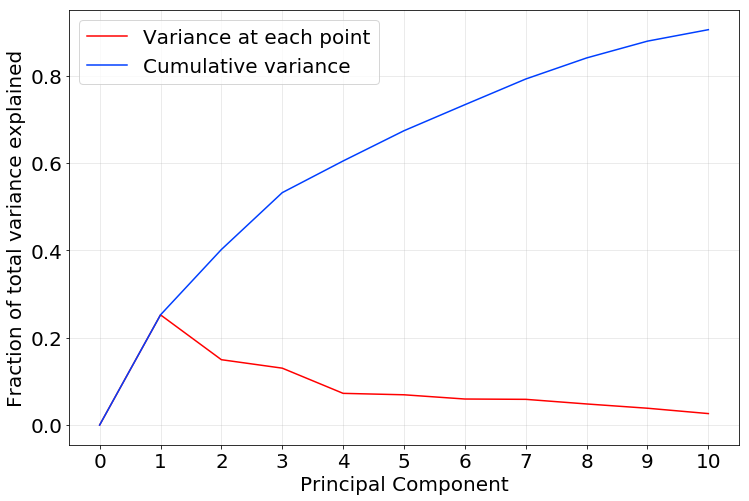

In [15]:
pca = PCA(10)
pca.fit(X_train[model_mask_cols])
plot_var(pca)

In [ ]:
pca.components_

## SVD

In [ ]:
svd = TruncatedSVD(n_components=10)
svd.fit(X_train[model_mask_cols])
plot_var(svd)

# Clustering Models
Clustering models to try:
    - k-means
    - Heirarchal clustering
        - Look into the neat visualizations in R!
Link [here](http://www.sthda.com/english/wiki/beautiful-dendrogram-visualizations-in-r-5-must-known-methods-unsupervised-machine-learning)
    - Neural net
Perform for both subjective (features only) and objective (including targets/possibly even only targets)

## Customer Profile

In [166]:
# df['theft/person'] = df['2015_theft_count'] / df['POP2010']

In [206]:
df.head()

,visit_date,prev_visit_date,prev_item_move_date,ship_id,address1,sales_rep_id,item_id,old_item_id,item_UPC,old_item_UPC,item_description,qty_POG_limit,qty_n,qty_f,qty_o,qty_d,qty_delivery,qty_sales,unit_price,qty_prev_end_inventory,qty_out,qty_start_inventory,qty_end_inventory,qty_inv_out,qty_ex_del,qty_shrink,qty_shrink_out,qty_shrink_ex_del,sales_value,shrink_value,shrink_to_sales_value_pct,shrink_value_out,shrink_to_sales_value_pct_out,shrink_value_ex_del,shrink_to_sales_value_pct_ex_del,ship_list_pk,sales_rep_id_2,address2,city,state,list_header_id,last_edit_date,creation_date,visit_date_int,prev_visit_date_int,prev_item_move_date_int,last_edit_date_int,creation_date_int,zip_code,qty_shrink_per_day,shrink_value_per_day,qty_shrink_per_day_lag1,shrink_value_per_day_lag1,qty_shrink_per_day_lag2,shrink_value_per_day_lag2,item_category_8,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_90,customer_id_2139,customer_id_1635139,customer_id_1903139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,item_category,customer_id,LAPOP1_10,POP2010,FD_ratio,unemp_rate,dens_sq_mile
3414634,2018-01-04,2017-12-07,2017-10-26,164431,7 ELEVEN SBT PROGRAM #39186,100197113,2973338,2973338,5254860446,5254860446,0711 STEREO EARBUDS W/MIC (BLACK),6,1,0,0,0,1,2,4.90,6.0,1,5,6,2.0,1.0,0.0,-1,-1.0,9.80,0.0,0.0,2.90,29.591837,-4.9,-50.0,152282,100197113,4200 WINTR GRDEN VINELAND,WINTER GARDEN,FL,4513311,2017-02-03 23:31:49,2016-08-23 07:37:37,1.515049e+09,1.512630e+09,1.508998e+09,1.486190e+09,1.471959e+09,34787,0.000000,0.000000,0.044643,0.136607,0.044643,0.136607,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156,248967.912835,1145956.0,0.217258,0.09,666.671489
4548441,2017-12-21,2017-11-30,2017-11-30,163005,7 ELEVEN SBT PROGRAM #35316,100304126,2378135,2378135,60870716205,60870716205,VL CAR CHRG W/DUAL USB 2.1A,20,11,0,0,0,0,5,2.45,20.0,11,9,20,11.0,11.0,6.0,6,6.0,12.25,14.7,120.0,21.95,179.183673,14.7,120.0,170566,100304126,2830 HANOVER ST,BALTIMORE,MD,4513311,2017-08-03 09:00:37,2017-02-05 10:00:32,1.513840e+09,1.512025e+09,1.512025e+09,1.501772e+09,1.486314e+09,21225,0.285714,0.700000,0.121212,0.684091,0.121212,0.684091,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156,204078.217061,537656.0,0.379570,0.14,5189.511139
3106537,2017-12-06,2017-11-15,2017-10-25,157884,7 ELEVEN SBT PROGRAM #11173,100282114,2450157,2450157,5254856843,5254856843,0711 SUCTION MOUNT SMARTPHONE HOLDER,2,0,0,1,0,0,1,4.20,2.0,0,3,2,-1.0,-1.0,-2.0,-1,-2.0,4.20,-8.4,-200.0,-1.00,-23.809524,-8.4,-200.0,156925,100282114,475 MERRICK RD,OCEANSIDE,NY,4513311,2016-09-23 09:01:08,2016-08-23 07:37:37,1.512544e+09,1.510729e+09,1.508911e+09,1.474643e+09,1.471959e+09,11572,-0.095238,-0.400000,0.000000,0.263492,0.000000,0.263492,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,16,2773156,76402.655059,1339532.0,0.057037,0.06,6389.550679
3172594,2018-01-04,2017-12-07,2017-11-29,68030,MAVERIK #388,100295126,2279857,889105,60870712447,60870711003,T8 TREND SG 11.99,2,1,0,0,0,0,-1,5.64,0.0,1,1,2,-1.0,-1.0,0.0,2,0.0,-5.64,0.0,0.0,6.64,-117.730496,0.0,0.0,128902,100295126,901 PENROD ROAD,SHOW LOW,AZ,4908309,2017-04-19 09:00:39,2016-08-23 07:37:37,1.515049e+09,1.512630e+09,1.511939e+09,1.492614e+09,1.471959e+09,85901,0.000000,0.000000,0.017857,0.117500,-0.050000,-0.352500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2139,43617.765192,107449.0,0.405939,0.10,66.117195
4572004,2018-01-03,2017-11-08,2017-09-06,157728,7 ELEVEN SBT PROGRAM #18555,100267114,2450144,2450144,5254856826,5254856826,0711 9 FT MICRO CABLE,

In [207]:
cust_table = df.groupby(['address1']).mean()[['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010',
                                              'FD_ratio', 'unemp_rate', 'dens_sq_mile', ]].reset_index()
cust_table.set_index('address1', inplace=True)

city_i = df.columns.get_loc('city')
state_i = df.columns.get_loc('state')
zip_i = df.columns.get_loc('zip_code')
cust_i = df.columns.get_loc('customer_id')
for index, row in cust_table.iterrows():
    foo = df[ df.address1 == index]
    for i, r in foo.iterrows():
        city = r[city_i]
        state = r[state_i]
        zip_code = r[zip_i]
        cust_id = r[cust_i]
        
        cust_table.set_value(index, 'city', city)
        cust_table.set_value(index, 'state', state)
        cust_table.set_value(index, 'zip_code', zip_code)
        cust_table.set_value(index, 'customer_id', cust_id)
        break

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [208]:
cust_table.head()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,customer_id
address1,,,,,,,,,,
#500 PACWEST/JACKSON,0.042262,0.512583,425363.0,0.228642,0.07,473.294897,BATTLE GROUND,WA,98604,3088198
#501 PACWEST/JACKSON,0.033853,0.284521,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198
#502 PACWEST/JACKSON,0.042468,0.395559,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198
#505 PACWEST/JACKSON,0.050510,0.262500,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198
#506 PACWEST/JACKSON,0.031169,0.230838,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198


In [633]:
dummy_cust = pd.get_dummies(cust_table, columns=['customer_id','zip_code'])
# including shrink and not inluding dummies
shrink_cust_mask = (dummy_cust.dtypes == float)
shrink_cust_cols = dummy_cust.columns[shrink_cust_mask]

# including dummies but not shrink
dummy_cust_mask = (dummy_cust.dtypes == float) | (dummy_cust.dtypes == np.uint8)
dummy_cust_cols = dummy_cust.columns[dummy_cust_mask]
dummy_cust_cols = list(dummy_cust_cols)
dummy_cust_cols.remove('qty_shrink_per_day')
dummy_cust_cols.remove('shrink_value_per_day')

# including dummies and shrink
all_cust_mask = (dummy_cust.dtypes == float) | (dummy_cust.dtypes == np.uint8)
all_cust_cols = dummy_cust.columns[dummy_cust_mask]

std_cust = std_f(dummy_cust.copy())

### Feature Importance

In [634]:
print('Shape before regularization: ',std_cust[dummy_cust_cols].shape)
lasso = Lasso(alpha=0.01)
lasso.fit(std_cust[dummy_cust_cols], std_cust['shrink_value_per_day'])
model = SelectFromModel(lasso, prefit=True)
std_cust_reduc = model.transform(std_cust[dummy_cust_cols])
print('Shape after regularization: ',std_cust_reduc.shape)
std_cust_reduc

Shape before regularization:  (9609, 4889)
Shape after regularization:  (9609, 4)


array([[-0.34913803, -0.49734688,  0.        ,  0.        ],
       [-0.04314867, -0.09047244,  0.        ,  0.        ],
       [-0.04314867, -0.09047244,  0.        ,  0.        ],
       ...,
       [-0.34913803, -0.2945647 ,  0.        ,  0.        ],
       [-0.04314867, -0.47615525,  0.        ,  0.        ],
       [-0.96111674,  0.00207891,  0.        ,  0.        ]])

In [394]:
print('Shape before regularization: ',std_cust[dummy_cust_cols].shape)
lsvr = LinearSVR(C=0.01, loss='epsilon_insensitive', dual=True)
lsvr.fit(std_cust[dummy_cust_cols], std_cust['shrink_value_per_day'])
model = SelectFromModel(lsvr, prefit=True)
std_cust_reduc = model.transform(std_cust[dummy_cust_cols])
print('Shape after regularization: ',std_cust_reduc.shape)
std_cust_reduc
model.get_support

Shape before regularization:  (9609, 60)
Shape after regularization:  (9609, 14)


<bound method SelectorMixin.get_support of SelectFromModel(estimator=LinearSVR(C=0.01, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
        norm_order=1, prefit=True, threshold=None)>

In [353]:
dummy_cust_cols

Index(['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010', 'FD_ratio',
       'unemp_rate', 'dens_sq_mile', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MT',
       'state_NC', 'state_NE', 'state_NH', 'state_NJ', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WA',
       'state_WI', 'state_WV', 'state_WY', 'customer_id_1635139',
       'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
       'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
       'customer_id_2977160', 'customer_id_3083182', 'customer_id_3088198',
       'customer_id_3088201', 'customer_id_3089336', 'customer_id_3093327',
       'cu

### Customer Clustering

In [ ]:
# columns to use in segmentation:
pca_cols = ['qty_shrink_per_day', 'shrink_value_per_day', 'FD_ratio', 'dens_sq_mile', 'POP2010', 'unemp_rate']
clusters = np.arange(1, 15)
SSE_arr, ss_arr = kmeansMB(std_cust[all_cust_cols], clusters)
#elbow(clusters, SSE_arr)
silhouette(np.arange(2, 15), ss_arr)

In [523]:
all_cust_cols

Index(['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010', 'FD_ratio',
       'unemp_rate', 'dens_sq_mile', 'customer_id_1635139',
       'customer_id_1903139', 'customer_id_2139', 'customer_id_2331150',
       'customer_id_2741156', 'customer_id_2773156', 'customer_id_2782156',
       'customer_id_2977160', 'customer_id_3083182', 'customer_id_3088198',
       'customer_id_3088201', 'customer_id_3089336', 'customer_id_3093327',
       'customer_id_3093329'],
      dtype='object')

In [524]:
cust_kmeans = KMeans(n_clusters=5, max_iter=10000, n_jobs=-1)
pred = cust_kmeans.fit_predict(std_cust[all_cust_cols])
dummy_cust['cluster'] = pred

In [525]:
dummy_cust.head()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,cluster,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329
address1,,,,,,,,,,,,,,,,,,,,,,,,
#500 PACWEST/JACKSON,0.042262,0.512583,425363.0,0.228642,0.07,473.294897,BATTLE GROUND,WA,98604,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
#501 PACWEST/JACKSON,0.033853,0.284521,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
#502 PACWEST/JACKSON,0.042468,0.395559,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
#505 PACWEST/JACKSON,0.050510,0.262500,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
#506 PACWEST/JACKSON,0.031169,0.230838,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [526]:
print(dummy_cust.groupby('cluster').count().city)
dummy_cust.groupby('cluster').mean()[all_cust_cols]

cluster
0    2135
1    3694
2    3246
3     469
4      65
Name: city, dtype: int64


,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329
cluster,,,,,,,,,,,,,,,,,,,,
0,0.165780,0.699652,5.246575e+05,0.236247,0.094923,1775.181697,0.002810,0.206557,0.014520,0.613583,0.000000,0.131616,0.003279,0.001405,0.001405,0.015457,0.000000,0.001874,0.001405,0.006089
1,0.009061,0.063892,1.313276e+06,0.147026,0.080704,4240.457991,0.000541,0.008392,0.022198,0.114781,0.000271,0.815106,0.002436,0.002707,0.001624,0.023281,0.000000,0.004873,0.000541,0.003249
2,0.024953,0.121348,5.691727e+05,0.326506,0.073460,1815.434461,0.000308,0.018484,0.056685,0.257548,0.001232,0.600123,0.003389,0.016944,0.008010,0.032348,0.000308,0.001232,0.000616,0.002773
3,0.019960,0.108761,9.227057e+06,0.070202,0.080789,10944.745960,0.000000,0.000000,0.000000,0.004264,0.000000,0.965885,0.000000,0.000000,0.000000,0.000000,0.000000,0.025586,0.002132,0.002132
4,0.037232,0.140545,2.042068e+06,0.010340,0.079231,56879.575465,0.000000,0.000000,0.000000,0.092308,0.000000,0.876923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015385,0.015385


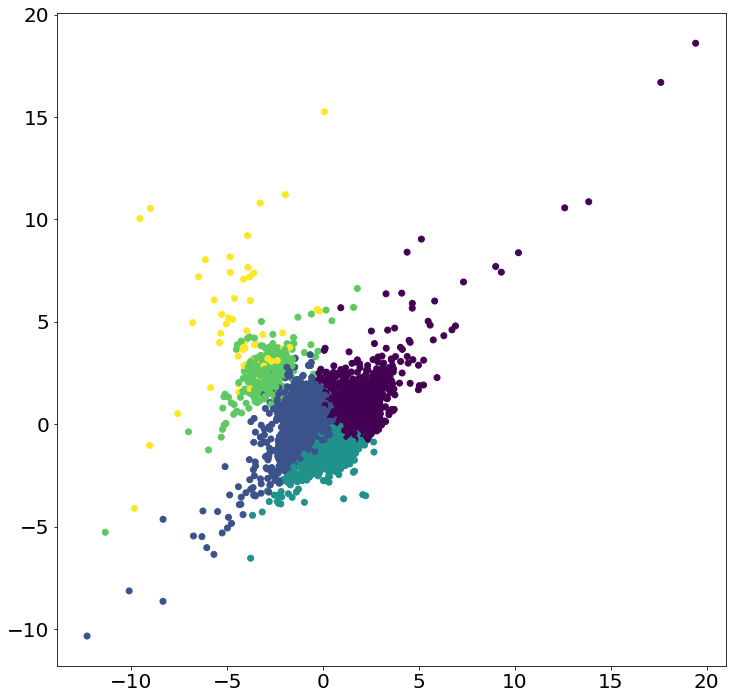

In [527]:
cust_pca = PCA(2)
pcas = cust_pca.fit_transform(std_cust[all_cust_cols])

plt.figure(figsize=(12,12))
plt.scatter(pcas[:,0], pcas[:,1], c=dummy_cust.cluster)

(-5.62512971983462, 5)

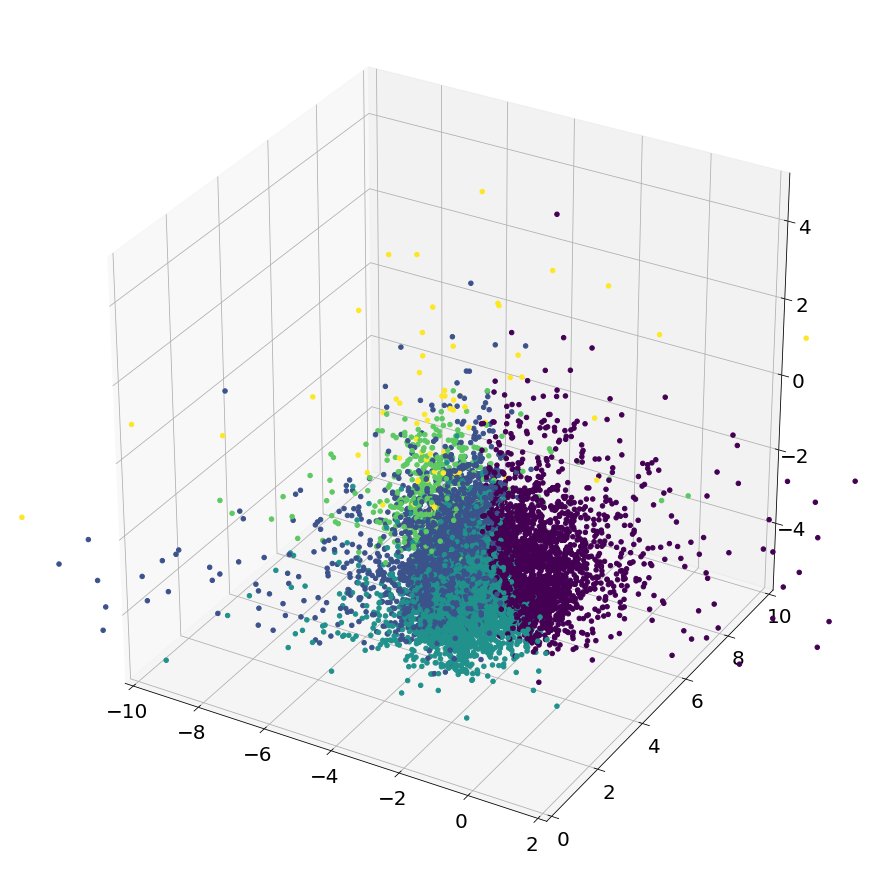

In [528]:
cust_pca = PCA(3)
pcas = cust_pca.fit_transform(std_cust[all_cust_cols])

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
ax.scatter(pcas[:,0], pcas[:,1], pcas[:,2], s=20, alpha=1, c=dummy_cust.cluster)
ax.set_xlim(left=-10, right=2)
ax.set_ylim(bottom=0, top=10)
ax.set_zlim(top=5)

In [542]:
#cust_table_clust = cust_table[['cluster']].astype(str)
cust_table_clust = dummy_cust[['cluster']].astype(str)
cust_table_clust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9609 entries, #500 PACWEST/JACKSON to SUPERAMERICA #9398
Data columns (total 1 columns):
cluster    9609 non-null object
dtypes: object(1)
memory usage: 470.1+ KB


## K-means

In [345]:
def kmeansMB(X_km, clusters):
    SSE_arr = []
    ss_arr = []
    for i in clusters:
        kmeans = MiniBatchKMeans(n_clusters=i)
        clust_dist = kmeans.fit_transform(X_km)
        clust_num = kmeans.predict(X_km)

        SSE = 0
        for a, b in zip(clust_dist, clust_num):
            SSE += a[b] ** 2
        SSE_arr.append(SSE)
        
        if i > 1:
            ss_arr.append(silhouette_score(X_km, clust_num))
    return SSE_arr, ss_arr

In [ ]:
clusters = np.arange(1, 20)
SSE_arr, ss_arr = kmeans(X_train[model_mask_cols], clusters)
elbow(clusters, SSE_arr)
silhouette(np.arange(2, 20), ss_arr)

In [149]:
def elbow(clusters, SSE_arr):
    plt.figure(figsize=(12,8))
    plt.title('Elbow Plot')
    plt.plot(clusters, SSE_arr)
    plt.grid(alpha=0.3)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squares Error (SSE)');

In [150]:
def silhouette(clusters, ss_arr):
    plt.figure(figsize=(12,8))
    plt.title('Silhouette Scores')
    plt.plot(clusters, ss_arr)
    plt.grid(alpha=0.3)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score');

## Heirarchal Clustering

In [196]:
def heir_clust(X_hc, thresh, dist_metric='cosine', num_params_to_display=50):
    # Find distances using pair-wise distances in the array, according to desired metric
    dist = squareform(pdist(X_hc.values.T, metric = dist_metric))

    # Plot dendrogram
    fig, axarr = plt.subplots(nrows = 3, ncols = 1, figsize=(60, 80))
    for ax, linkmethod in zip(axarr.flatten(), ['single', 'complete', 'average']):
        clust = linkage(dist, method=linkmethod)
        dendrogram(clust, ax=ax, truncate_mode='lastp', p=num_params_to_display, labels=model_mask_cols, 
                   color_threshold=thresh, leaf_font_size=25) #color threshold number sets the color change
        ax.set_title('{} linkage'.format(linkmethod), fontsize=40)
        ax.grid(alpha=0.3)
    plt.savefig('images/clust.png'.format(linkmethod))

In [ ]:
heir_clust(X_train[model_mask_cols], thresh=1.6)

# Regression Models
Regression models to try:
    - Linear regression (with additional complexity)
    - Random forest
    - Boosting
    - Gradient descent
    - Neural net

## OLS

In [87]:
def ols(X_train, X_test, y_train, y_test):
    ols = OLS(y_train, add_constant(X_train.values, has_constant='add'))
    result = ols.fit()
    pred = result.predict(add_constant(X_test.values, has_constant='add'))
    score = mean_squared_error(y_test, pred)
    print('Root Mean Square Error: ',score)
    names = list(X_train.columns)
    names.insert(0,'Constant')
    print(result.summary(xname=names))

In [88]:
ols(X_train[model_mask_cols], X_test[model_mask_cols], y_train, y_test)

Root Mean Square Error:  3.1606941053930613
                             OLS Regression Results                             
Dep. Variable:     shrink_value_per_day   R-squared:                       0.260
Model:                              OLS   Adj. R-squared:                  0.259
Method:                   Least Squares   F-statistic:                     806.4
Date:                  Thu, 18 Jan 2018   Prob (F-statistic):               0.00
Time:                          16:32:56   Log-Likelihood:            -1.4132e+05
No. Observations:                 87341   AIC:                         2.827e+05
Df Residuals:                     87302   BIC:                         2.831e+05
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [ ]:
for val in X_train.item_category.unique():
    print('Item cat: ', val)
    mask = X['item_category_{}'.format(val)] == 1
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X[mask], y[mask], test_size=0.2)
    size = len(X_train_temp)
    print('Size: ', size)
    if size < 30:
        continue
    ols(X_train_temp[model_mask_cols], X_test_temp[model_mask_cols], y_train_temp, y_test_temp)

## multiple Sklear models

In [73]:
def class_crossval(X, y, models, scoring='neg_mean_absolute_error'):
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.2f} ({:2f})'.format(name, cv_results.mean(), cv_results.std()))
    
    fig = plt.figure(figsize=(25, 18))
    plt.tight_layout()
    fig.suptitle('Algorithm Comparison of CrossVal Scores')
    ax = fig.add_subplot(111)
    sb.violinplot(data=results, orient='v')
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('K-Fold CV Negative Mean Abs. Error')
    ax.set_xlabel('Model')
    plt.grid(alpha=0.4)
    #plt.savefig('images/model_selection_shrink_value.png')

Mod - Avg - Std Dev
---   ---   -------
Linear Regression: -0.37 (0.011550)
Ridge Regression: -0.37 (0.011546)
Lasso Regression: -0.56 (0.010618)
Elastic Net: -0.56 (0.010618)
K Nearest Neighbors: -0.44 (0.011165)
Decision Tree: -0.32 (0.018802)
Random Forest: -0.25 (0.012958)
Gradient Boost: -0.34 (0.011859)
Multi-Layer Perceptron: -0.28 (0.033201)
Avg of all: -0.388


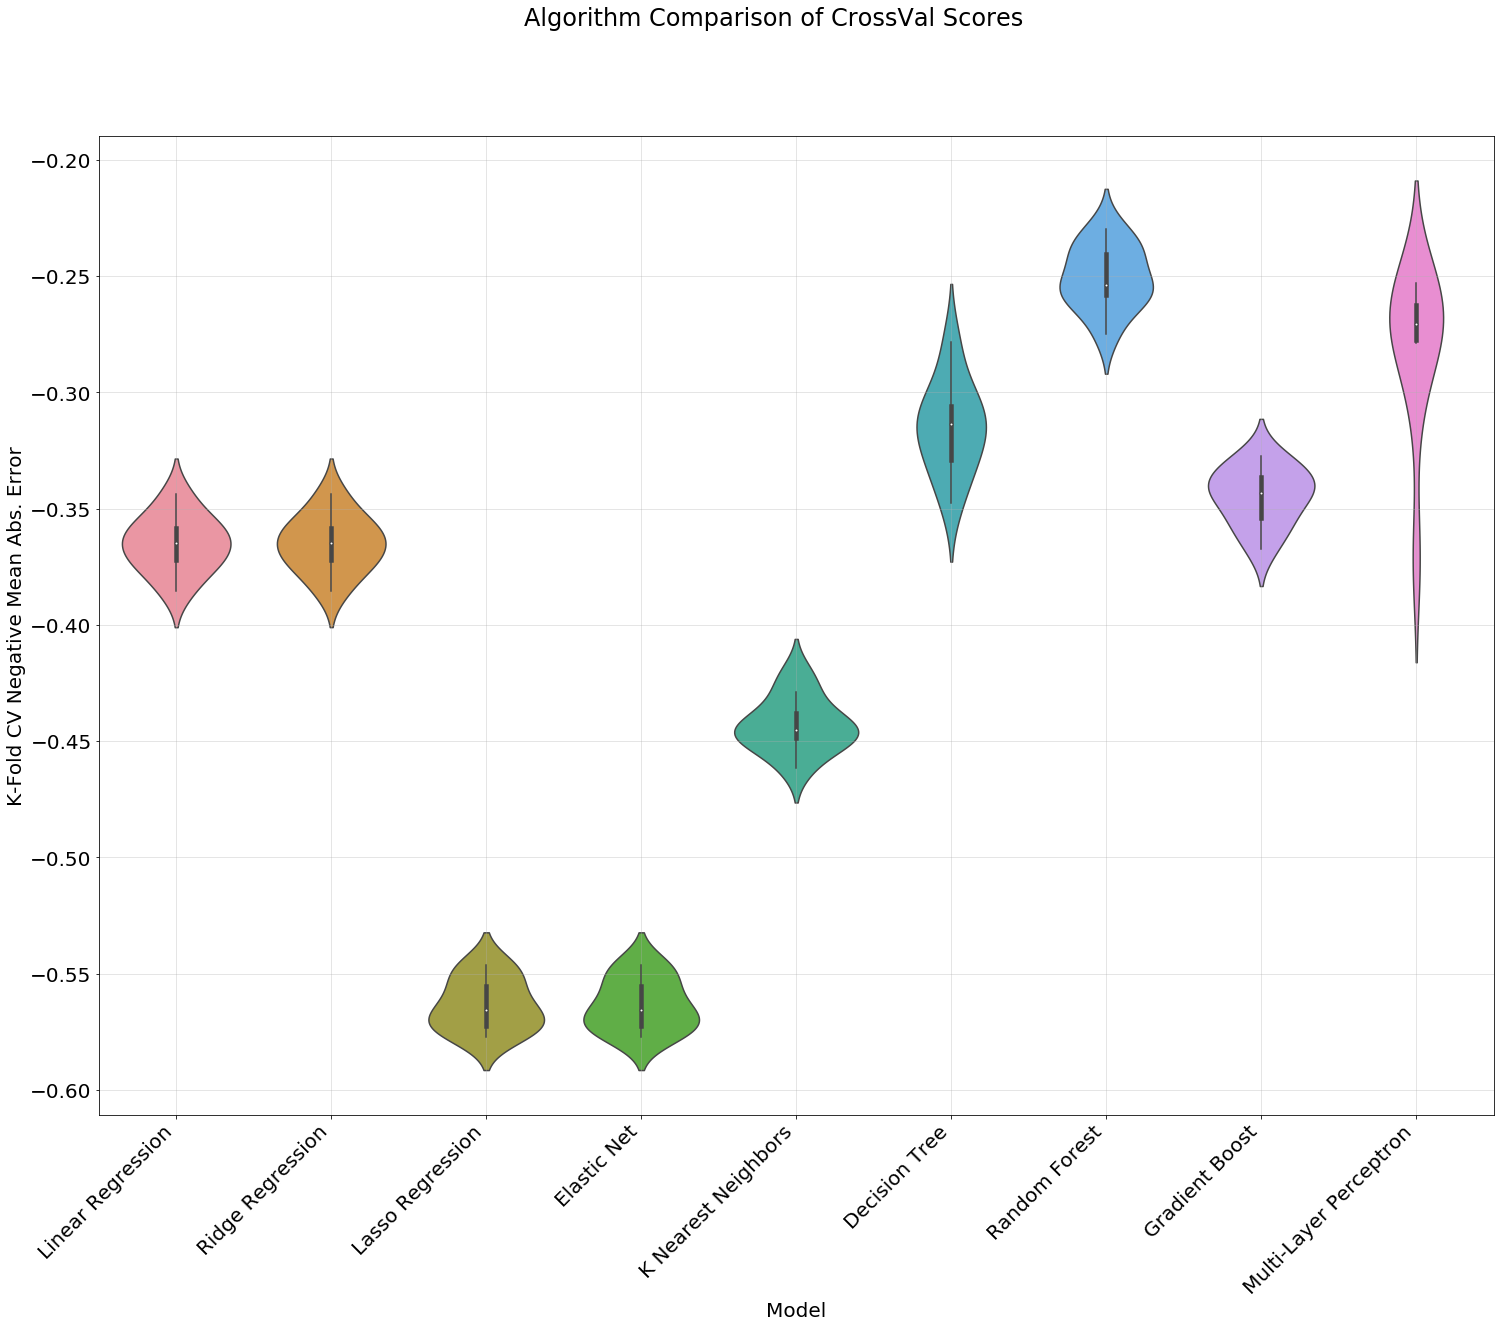

In [79]:
# Initial Cross Validation
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Elastic Net', ElasticNet()))
#models.append(('Stochastic Gradient Descent', SGDRegressor(max_iter=10000, tol=0.001)))
#models.append(('Support Vector Regression', SVR(max_iter=10000)))
models.append(('K Nearest Neighbors', KNeighborsRegressor(n_jobs=-1)))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
#models.append(('AdaBoost', AdaBoostRegressor(n_estimators=100)))
models.append(('Gradient Boost', GradientBoostingRegressor()))
models.append(('Multi-Layer Perceptron', MLPRegressor(alpha=1)))

class_crossval(X_train[model_mask_cols], y_train, models)

## Random Forest

In [615]:
def model_grid_plus_error(model, param_grid, X_train, X_test, y_train, y_test):
    test_model = model
    grid = GridSearchCV(test_model, param_grid=param_grid, verbose=1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return grid, mean_squared_error(y_test, y_pred)

In [616]:
model = RandomForestRegressor()
params = {'n_estimators': [10, 30], 'max_features': [5, 10, 15], 'max_depth': [None, 20], 'n_jobs': [-1]}
grid, mse = model_grid_plus_error(model, params, X_train[model_mask_cols], X_test[model_mask_cols], y_train, y_test)
print(mse)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_va

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_va

KeyboardInterrupt: 

## MLP

In [629]:
model = MLPRegressor()
params = {'hidden_layer_sizes': [(50,50)], 'alpha': [0.000001, 0.00001, 0.0001, 0.001], 'max_iter': [100]}
grid, mse = model_grid_plus_error(model, params, X_train[model_mask_cols], X_test[model_mask_cols], y_train, y_test)
print(mse)
print(grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.6min finished


0.9287042548382322
{'alpha': 1e-06, 'hidden_layer_sizes': (50, 50), 'max_iter': 100}


# Splitting By Cluster

Average:  0.40561269029072144
Std. Dev.:  1.532391323064075


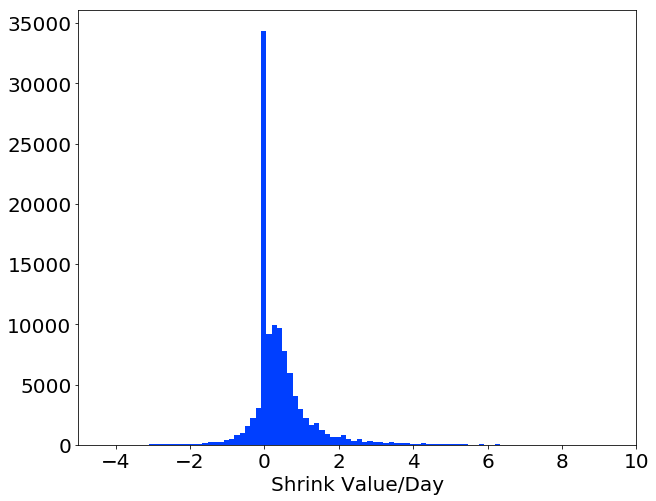

In [504]:
value_dist = df.shrink_value_per_day.values
plt.figure(figsize=(10,8))
plt.hist(value_dist, bins=2000)
#plt.yscale('log')
plt.xlim(xmin=-5, xmax=10)
plt.xlabel('Shrink Value/Day')

print('Average: ', value_dist.mean())
print('Std. Dev.: ',value_dist.std())

In [554]:
X_train.groupby('cluster').count()

,FD_ratio,LAPOP1_10,POP2010,address1,address2,city,creation_date,creation_date_int,customer_id,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_UPC,item_category,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,item_description,item_id,last_edit_date,last_edit_date_int,list_header_id,old_item_UPC,old_item_id,prev_item_move_date,prev_item_move_date_int,prev_visit_date,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1,qty_shrink_per_day_lag2,qty_start_inventory,sales_rep_id,sales_rep_id_2,sales_value,ship_id,ship_list_pk,shrink_value_per_day_lag1,shrink_value_per_day_lag2,state,unemp_rate,unit_price,visit_date,visit_date_int,zip_code
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993,41993
1,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837,18837
2,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364,25364
3,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041
4,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106


In [559]:
def model_clusters(model, X_train, X_test, col_mask, y_train, y_test):
    cluster_rmse = []
    cluster_models = []
    for clust in range(0, len(X_train.cluster.unique())):
        print(clust)
        train_clust_mask = X_train.cluster == str(clust)
        test_clust_mask = X_test.cluster == str(clust)
        clust_model = model
        clust_model.fit(X_train[col_mask][train_clust_mask], y_train[train_clust_mask])
        y_pred = clust_model.predict(X_test[col_mask][test_clust_mask])
        cluster_rmse.append(np.sqrt(mean_squared_error(y_test[test_clust_mask], y_pred)))
        cluster_models.append(clust_model)
    return cluster_rmse, cluster_models

In [630]:
cluster_rmse, cluster_models = model_clusters(MLPRegressor(alpha=0.00001, hidden_layer_sizes=(50,50)),  
                                             X_train, X_test, model_mask_cols,y_train, y_test)

0
1
2
3
4


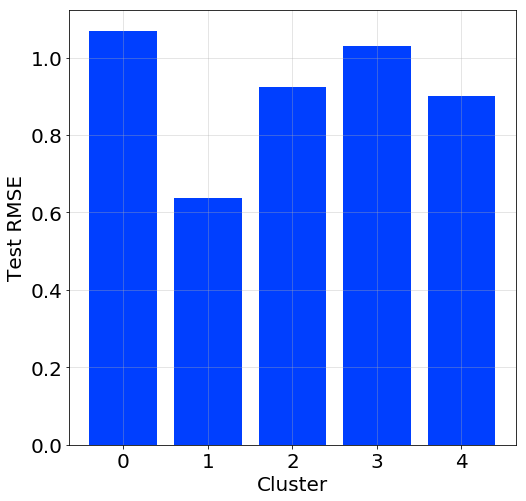

In [631]:
plt.figure(figsize=(8,8))
plt.bar(np.arange(0,len(X_train.cluster.unique())), cluster_rmse)
plt.xlabel('Cluster')
plt.ylabel('Test RMSE')
plt.grid(alpha=0.4)

# Forcasting

What model should look like:
1. Take grouped row for one store on one date:
    - Run through that store's model to predict shrink_value on that date
    

In [610]:
forc_X_train.groupby(['address1', 'visit_date']).mean()

FD_ratio  LAPOP1_10   POP2010  \
address1             visit_date                                  
#500 PACWEST/JACKSON 2017-09-20 -0.151243  -0.248977 -0.209223   
                     2017-10-11 -0.151243  -0.248977 -0.209223   
                     2017-11-01 -0.151243  -0.248977 -0.209223   
                     2017-11-21 -0.151243  -0.248977 -0.209223   
#501 PACWEST/JACKSON 2017-10-11 -0.151243  -0.248977 -0.209223   
                     2017-11-01 -0.151243  -0.248977 -0.209223   
                     2017-11-21 -0.151243  -0.248977 -0.209223   
#502 PACWEST/JACKSON 2017-09-20 -0.151243  -0.248977 -0.209223   
                     2017-10-11 -0.151243  -0.248977 -0.209223   
                     2017-11-01 -0.151243  -0.248977 -0.209223   
                     2017-11-21 -0.151243  -0.248977 -0.209223   
#505 PACWEST/JACKSON 2017-09-21 -1.398048  -0.463322  0.098476   
                     2017-11-02 -1.398048  -0.463322  0.098476   
                     2017-11-22 -1.398048  -0.463322  0.098476   
#506 PACWEST/JACKSON 2017-09-21 -1.398048  -0.463322  0.098476   
                     2017-10-13 -1.398048  -0.463322  0.098476   
                     2017-11-02 -1.398048  -0.463322  0.098476   
#508 PACWEST/JACKSON 2017-11-22 -1.398048  -0.463322  0.098476   
                     2017-11-28 -1.398048  -0.463322  0.098476   
#509 PACWEST/JACKSON 2017-09-06 -1.398048  -0.463322  0.098476   
                     2017-09-28 -1.398048  -0.463322  0.098476   
                     2017-10-19 -1.398048  -0.463322  0.098476   
                     2017-11-30 -1.398048  -0.463322  0.098476   
#511 PACWEST/JACKSON 2017-10-15 -1.127171  -0.500361 -0.105640   
                     2017-11-27 -1.127171  -0.500361 -0.105640   
#512 PACWEST/JACKSON 2017-09-03 -1.127171  -0.500361 -0.105640   
                     2017-10-15 -1.127171  -0.500361 -0.105640   
                     2017-11-06 -1.127171  -0.500361 -0.105640   
                     2017-11-27 -1.127171  -0.500361 -0.105640   
#513 PACWEST/JACKSON 2017-10-15 -1.127171  -0.500361 -0.105640   
...                                   ...        ...       ...   
SPEEDWAY #9925       2017-08-01 -0.966117  -1.003383 -0.602303   
                     2017-08-15 -0.966117  -1.003383 -0.602303   
                     2017-08-29 -0.966117  -1.003383 -0.602303   
                     2017-09-21 -0.966117  -1.003383 -0.602303   
                     2017-10-05 -0.966117  -1.003383 -0.602303   
                     2017-10-20 -0.966117  -1.003383 -0.602303   
                     2017-11-03 -0.966117  -1.003383 -0.602303   
                     2017-11-17 -0.966117  -1.003383 -0.602303   
                     2017-11-30 -0.966117  -1.003383 -0.602303   
SPEEDWAY #9926       2017-08-08 -1.363324  -0.959179 -0.535855   
                     2017-09-05 -1.363324  -0.959179 -0.535855   
                     2017-10-02 -1.363324  -0.959179 -0.535855   
                     2017-10-16 -1.363324  -0.959179 -0.535855   
                     2017-10-30 -1.363324  -0.959179 -0.535855   
                     2017-11-13 -1.363324  -0.959179 -0.535855   
                     2017-11-27 -1.363324  -0.959179 -0.535855   
SPEEDWAY #9975       2017-07-20  0.930879  -0.198223 -0.332321   
                     2017-08-03  0.930879  -0.198223 -0.332321   
                     2017-08-29  0.930879  -0.198223 -0.332321   
                     2017-09-15  0.930879  -0.198223 -0.332321   
                     2017-09-29  0.930879  -0.198223 -0.332321   
                     2017-10-27  0.930879  -0.198223 -0.332321   
                     2017-11-25  0.930879  -0.198223 -0.332321   
SUPERAMERICA #9398   2017-08-29 -0.276002  -0.520818 -0.337833   
                     2017-09-12 -0.276002  -0.520818 -0.337833   
                     2017-09-26 -0.276002  -0.520818 -0.337833   
                     2017-10-10 -0.276002  -0.520818 -0.337833   
                     2017-10-24 -0.276002  -0.520818 -0.337833   
       

In [611]:
forc_X_test.groupby(['address1', 'visit_date']).mean()

,,FD_ratio,LAPOP1_10,POP2010,creation_date_int,customer_id_1635139,customer_id_1903139,customer_id_2139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,customer_id_3097348,dens_sq_mile,item_category_10,item_category_16,item_category_19,item_category_26,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_8,item_category_90,last_edit_date_int,prev_item_move_date_int,prev_visit_date_int,qty_POG_limit,qty_prev_end_inventory,qty_sales,qty_shrink_per_day_lag1,qty_shrink_per_day_lag2,qty_start_inventory,sales_value,shrink_value_per_day_lag1,shrink_value_per_day_lag2,unemp_rate,unit_price,visit_date_int
address1,visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#501 PACWEST/JACKSON,2017-12-13,-0.092026,-0.391752,-0.310298,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.129391,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.821249,0.902725,-0.456772,-0.437300,-0.454689,-0.030269,-0.183278,-0.503000,-0.517642,0.366603,-0.072196,-0.092336,-0.294521,0.946399
#502 PACWEST/JACKSON,2017-12-13,-0.092026,-0.391752,-0.310298,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.129391,0.500000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.842093,0.902725,-0.456772,-0.380088,-0.454689,-0.189834,-0.182967,-0.423123,-0.517642,-0.126710,-0.121102,-0.092336,1.110999,0.946399
#506 PACWEST/JACKSON,2017-12-14,-1.320495,-0.563930,-0.114682,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.951339,0.333333,0.666667,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.864951,0.904710,-0.384613,-0.361017,-0.271233,-0.242798,-0.328809,-0.476374,0.097374,-0.114530,-0.391343,-0.704513,0.462593,0.948384
#508 PACWEST/JACKSON,2017-12-14,-1.320495,-0.563930,-0.114682,0.548627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.385119,0.500000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.893433,0.916621,-0.276375,-0.256128,-0.454689,2.346511,1.959129,-0.449748,-0.517642,4.582686,3.728787,0.213753,0.212353,0.948384
#509 PACWEST/JACKSON,2017-12-21,-1.320495,-0.563930,-0.114682,0.532731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.110810,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.920592,0.920592,0.336975,0.172963,-0.087777,-0.127575,-0.152873,0.269148,0.466123,0.052236,0.073711,-0.092336,0.081478,0.962281
#511 PACWEST/JACKSON,2017-12-18,-1.053601,-0.593683,-0.244447,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.442058,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.851068,0.914636,0.057360,0.106216,-0.317097,0.004365,-0.092063,0.136019,-0.359816,0.248129,0.338209,-0.398424,-0.263827,0.956325
#512 PACWEST/JACKSON,2017-12-18,-1.053601,-0.593683,-0.244447,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.364857,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.914636,0.914636,-0.402653,-0.437300,-0.317097,-0.304870,-0.284186,-0.423123,-0.175605,-0.377740,-0.343731,-0.398424,0.217042,0.956325
#513 PACWEST/JACKSON,2017-12-18,-1.053601,-0.593683,-0.244447,0.499221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.442058,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.584794,0.914636,0.914636,-0.240295,-0.208451,-0.454689,-0.045112,-0.046455,-0.103613,-0.517642

## LSTM

In [ ]:
def fit_lstm(X, y, batch_size, nb_epoch, neurons):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(X_train[model_mask_cols], y_train, 1, 3, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# Forcasting/Time Series
 - Inclusion of endog (target) variable into predictive model/forcast
 - Explore various techniques outlined statsmodels.pdf
 - Try LSTM neural net

In [ ]:
plt.scatter(X_train.prev_item_move_date_int.values, X_train.prev_visit_date_int.values, alpha=0.01)

In [ ]:
foo = df[ df.address1 == 'SPEEDWAY #1224']
plt.figure(figsize=(12,12))
plt.scatter(foo.visit_date.values, foo.qty_shrink.values, c=foo.item_UPC.values)
plt.xticks(rotation=45)
plt.legend()

In [ ]:
def cat_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Cat')
    
cat_plot_sales()

In [ ]:
def cat_plot_shrink():
    freq = '2w'
    item_filt = df.groupby(['item_category', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(12,12))
    i = 1
    for cat in item_filt.item_category.unique():
        if cat == '41':
            continue
        foo = item_filt[ item_filt.item_category == cat]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.qty_shrink, label=cat)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Shrink/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Shrink Loss Across All Stores by Cat')
    
    
cat_plot_shrink()

In [ ]:
def st_plot_sales():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.sales_value, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Lost Sales/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Sales Loss Across Cat by State')
    
st_plot_sales()

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


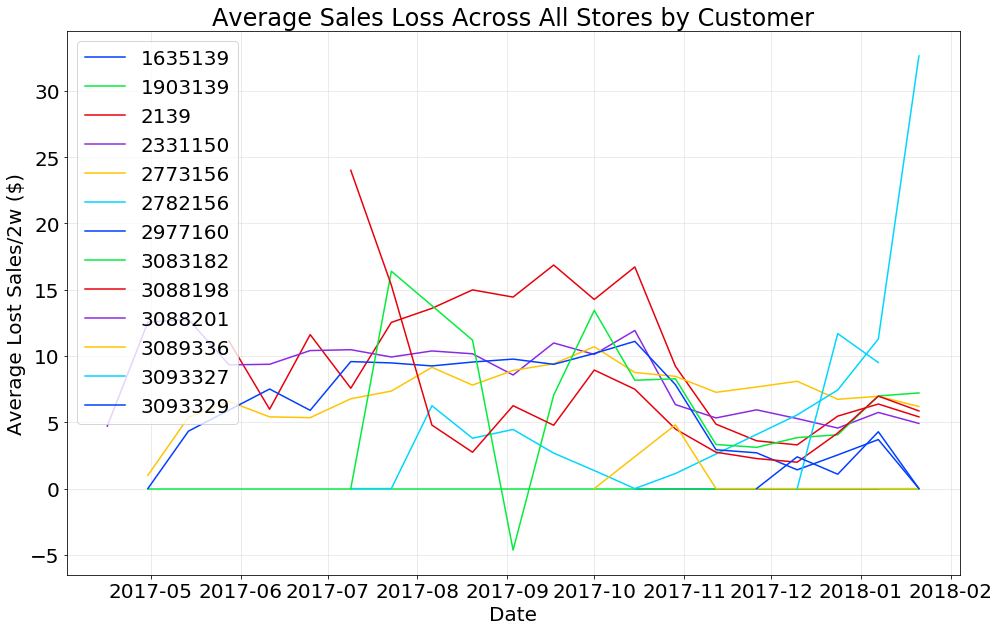

In [582]:
def cust_plot_sales():
    freq = '2w'
    item_filt = df.groupby(['customer_id', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(16,10))
    plt.tight_layout()
    i = 1
    for cust in item_filt.customer_id.unique():
        if cust == '2741156':
            continue
        foo = item_filt[ item_filt.customer_id == cust]
        ax = fig.add_subplot(1,1,1)
        ax.plot(foo.visit_date, foo.sales_value, label=cust)
        #ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
    plt.legend()
    plt.ylabel('Average Lost Sales/{} ($)'.format(freq))
    plt.xlabel('Date')
    plt.grid(alpha=0.3)
    plt.title('Average Sales Loss Across All Stores by Customer')
    #plt.yscale('log')
    
    
cust_plot_sales()

In [ ]:
plt.figure(figsize=(20,4))
plt.scatter(df.visit_date.values, df.shrink_value.values, alpha=0.2)
plt.yscale('log')
plt.yticks([0.1,1,10])


In [ ]:
df.groupby(['state', pd.Grouper(key='visit_date', freq='w')]).head()

In [ ]:
def st_plot_shrink():
    freq = '20d'
    item_filt = df.groupby(['state', pd.Grouper(key='visit_date', freq=freq)]).mean().reset_index()
    fig = plt.figure(figsize=(40,60))
    i = 1
    count = 0
    for state in item_filt.state.unique():
        count += 1
        if count % 9 == 0:
            i += 1
        foo = item_filt[ item_filt.state == state]
        ax = fig.add_subplot(3,2,i)
        ax.plot(foo.visit_date, foo.qty_shrink, label=state)
        ax.set_xticklabels(foo.visit_date, rotation=45, ha='right')
        ax.legend()
        ax.set_ylabel('Average Shrink/{} ($)'.format(freq))
        ax.set_xlabel('Date')
        ax.grid(alpha=0.3)
        ax.set_title('Average Shrink Loss Across Cat by State')
    
st_plot_shrink()

In [ ]:
crime = pd.read_pickle('data/Crime/crime_clean.pkl')

In [ ]:
def crime_plot():
    freq = 'w'
    item_filt = crime.groupby([pd.Grouper(key='date', freq=freq)]).count().reset_index()
    plt.figure(figsize=(20,8))
    plt.plot(item_filt.date, item_filt.city)
    plt.grid(alpha=0.4)
crime_plot()

In [ ]:
def fit_lstm(X_train, y, batch_size, nb_epoch, neurons):
    X = X_train[]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
fit_lstm(X_train, y, None, 1, 20)

# Questions
1. Why are there two salesman ID columns?
2. Which columns are unknown (ie anything inventory out or equivalent)?
3. Target is qty_shrink?
4. What does customer_id represent? It has more values than address1

# Other Data Sources
 - Crime data
 - Food desserts (people that may rely on gas stations for food)
 - Average income
 - Population density

In [ ]:
pd.get_dummies(df, columns=['state'])

In [ ]:
foo = pd.DataFrame()
foo[['a', 'b']] = df[['visit_date', 'address1']]

In [ ]:
foo.head()

# POA
- Create averages:
    - Avg qty shrink/day, shink_sales/day, etc
- Engineer lag terms (ie last visit, last month, last season)
    - Use these in whatever model I want
    - Use the averaged values